# Classification: KNeighbors and Logistic regression

In [1]:
import sys
sys.path.append('..')

In [2]:
from source.code.data_loader import DataLoader
from source.code.data_loader import ItemSelector
from source.code.data_loader import MyImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns; sns.set(style="ticks", color_codes=True)

from imblearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

## Auxiliary methods

In [4]:
def show_quality_results(y_test, k_n_y_pred, l_r_y_pred):
    k_n_precision_sc = precision_score(y_test, k_n_y_pred)
    k_n_accuracy_sc = accuracy_score(y_test, k_n_y_pred)
    k_n_recall_sc = recall_score(y_test, k_n_y_pred)
    k_n_f1_sc = f1_score(y_test, k_n_y_pred)
    k_n_conf_matrix = confusion_matrix(y_test, k_n_y_pred)

    l_r_precision_sc = precision_score(y_test, l_r_y_pred)
    l_r_accuracy_sc = accuracy_score(y_test, l_r_y_pred)
    l_r_recall_sc = recall_score(y_test, l_r_y_pred)
    l_r_f1_sc = f1_score(y_test, l_r_y_pred)
    l_r_conf_matrix = confusion_matrix(y_test, l_r_y_pred)
    
    f, axs = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(k_n_conf_matrix, annot=True, fmt="d", ax=axs[0])
    sns.heatmap(l_r_conf_matrix, annot=True, fmt="d", ax=axs[1])
    axs[0].set_title("K-nearest neighbours\nPrecision: {0:f},\nRecall: {1:f},\nF-score: {2:f},\nAccuracy: {3:f}".format(k_n_precision_sc, k_n_recall_sc, k_n_f1_sc, k_n_accuracy_sc))
    axs[1].set_title("Logistic regression\nPrecision: {0:f},\nRecall: {1:f},\nF-score: {2:f},\nAccuracy: {3:f}".format(l_r_precision_sc, l_r_recall_sc, l_r_f1_sc, l_r_accuracy_sc))
    axs[0].set_xlabel("Predicted classes")
    axs[1].set_xlabel("Predicted classes")
    axs[0].set_ylabel("True classes")
    axs[1].set_ylabel("True classes")
    plt.show()

In [7]:
def find_the_best_classifier(X, y, base_classifier, grid_search_params, metric_to_maximize):
    # Здесь, пожалуй, стоит подчеркнуть важность выбора в сторону стратифицированной валидации, поскольку речь идет о задаче классификации.
    # Данный тип валидации сохраняет пропорцию классов в фолдах, так что мы можем предполагать, что разброс значений метрик на тесте не будет высоким.
    grid_search = GridSearchCV(
        estimator=base_classifier,
        param_grid=grid_search_params,
        cv=StratifiedKFold(n_splits=6),
        scoring={'accuracy': make_scorer(accuracy_score),
                 'precision': make_scorer(precision_score),
                 'recall': make_scorer(recall_score),
                 'f1': make_scorer(f1_score)},
        refit=metric_to_maximize,
        n_jobs=8
    )
    grid_search.fit(X, y)
    return grid_search

## Initial data loading

In [8]:
with open('../data/description/datasets', 'r') as source:
    datasets = source.readlines()
datasets = [dataset.replace('\n', '') for dataset in datasets]
dataset_path_pattern = '../data/{}/{}.{}.txt'
data_paths = [dataset_path_pattern.format('train', dataset, 'data') for dataset in datasets] + [dataset_path_pattern.format('test', dataset, 'test') for dataset in datasets]
data_loader = DataLoader(data_paths, '../data/description/columns', '../data/description/classes')
data_frame = data_loader.load()

## Dataset description

Собственно датасет представляет собой описание симптомов пациентов.

Цель - определение заболевания щитовидной железы (диагноз - целевая переменная).

Данные резбиты на несколько файлов, шесть пар файлов (для обучения и контроля) имеют одинаковою структуру, остальные отличаются по количеству признаков и порядку следования.

В данной работе используются только эти шесть пар файлов.

Также стоит отметить, что целевая переменная в разных файлах имеет разное количество разных диагнозов, однако все в целом могут быть разделены на две группы: здоров, болен.

Здесь задача многоклассовой классификации сводится к бинарной.

## EDA

In [9]:
data_frame.head()

age  sex  on thyroxine  query on thyroxine  on antithyroid medication  \
0  41.0  1.0         False               False                      False   
1  23.0  1.0         False               False                      False   
2  46.0  0.0         False               False                      False   
3  70.0  1.0          True               False                      False   
4  70.0  1.0         False               False                      False   

    sick  pregnant  thyroid surgery  I131 treatment  query hypothyroid  \
0  False     False            False           False              False   
1  False     False            False           False              False   
2  False     False            False           False              False   
3  False     False            False           False              False   
4  False     False            False           False              False   

     ...      TT4 measured    TT4  T4U measured   T4U  FTI measured    FTI  \
0    ...              True  125.0          True  1.14          True  109.0   
1    ...              True  102.0         False   NaN         False    NaN   
2    ...              True  109.0          True  0.91          True  120.0   
3    ...              True  175.0         False   NaN         False    NaN   
4    ...              True   61.0          True  0.87          True   70.0   

   TBG measured   TBG  referral source  diagnosis  
0         False  None             SVHC      False  
1         False  None            other      False  
2         False  None            other      False  
3         False  None            other      False  
4         False  None              SVI      False  

[5 rows x 30 columns]

In [10]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22632 entries, 0 to 971
Data columns (total 30 columns):
age                          22626 non-null float64
sex                          21732 non-null float64
on thyroxine                 22632 non-null bool
query on thyroxine           22632 non-null bool
on antithyroid medication    22632 non-null bool
sick                         22632 non-null bool
pregnant                     22632 non-null bool
thyroid surgery              22632 non-null bool
I131 treatment               22632 non-null bool
query hypothyroid            22632 non-null bool
query hyperthyroid           22632 non-null bool
lithium                      22632 non-null bool
goitre                       22632 non-null bool
tumor                        22632 non-null bool
hypopituitary                22632 non-null bool
psych                        22632 non-null bool
TSH measured                 22632 non-null bool
TSH                          20418 non-null float64
T3

In [11]:
data_frame.describe()

age           sex           TSH            T3           TT4  \
count  22626.000000  21732.000000  20418.000000  18018.000000  21246.000000   
mean      51.735879      0.684705      5.086766      2.013500    108.319345   
std       20.082739      0.464644     24.518468      0.827319     35.600058   
min        1.000000      0.000000      0.005000      0.050000      2.000000   
25%       36.000000      0.000000      0.500000      1.600000     88.000000   
50%       54.000000      1.000000      1.400000      2.000000    103.000000   
75%       67.000000      1.000000      2.700000      2.400000    124.000000   
max      455.000000      1.000000    530.000000     10.600000    430.000000   

                T4U           FTI  
count  20310.000000  20322.000000  
mean       0.995000    110.469649  
std        0.195433     33.085627  
min        0.250000      2.000000  
25%        0.880000     93.000000  
50%        0.980000    107.000000  
75%        1.080000    124.000000  
max        2.320000    395.000000

После объединения могло возникнуть некоторое количество дупликатов, попробуем от них избавиться:

In [12]:
data_frame.drop_duplicates(inplace=True)

In [13]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4619 entries, 0 to 909
Data columns (total 30 columns):
age                          4618 non-null float64
sex                          4435 non-null float64
on thyroxine                 4619 non-null bool
query on thyroxine           4619 non-null bool
on antithyroid medication    4619 non-null bool
sick                         4619 non-null bool
pregnant                     4619 non-null bool
thyroid surgery              4619 non-null bool
I131 treatment               4619 non-null bool
query hypothyroid            4619 non-null bool
query hyperthyroid           4619 non-null bool
lithium                      4619 non-null bool
goitre                       4619 non-null bool
tumor                        4619 non-null bool
hypopituitary                4619 non-null bool
psych                        4619 non-null bool
TSH measured                 4619 non-null bool
TSH                          4286 non-null float64
T3 measured          

In [14]:
data_frame.describe()

age          sex          TSH           T3          TT4  \
count  4618.000000  4435.000000  4286.000000  3778.000000  4442.000000   
mean     52.066046     0.694701     7.068102     2.007740   109.621027   
std      20.077794     0.460586    30.597431     0.963957    40.885925   
min       1.000000     0.000000     0.005000     0.050000     2.000000   
25%      36.000000     0.000000     0.410000     1.500000    86.000000   
50%      55.000000     1.000000     1.400000     2.000000   104.000000   
75%      68.000000     1.000000     3.200000     2.400000   129.000000   
max     455.000000     1.000000   530.000000    10.600000   430.000000   

               T4U          FTI  
count  4247.000000  4249.000000  
mean      1.002579   111.270981  
std       0.215204    38.158859  
min       0.250000     2.000000  
25%       0.870000    92.000000  
50%       0.980000   107.000000  
75%       1.090000   126.000000  
max       2.320000   395.000000

Судя по всему подавляющее большинство информации в датастах было дуплицировано.
Это также может быть объяснено тем, что все случаи положительных диагнозов были схлопнуты в один, поэтому пациенты с одинаковыми симптомами, но разными диагнозами из разных выборок стали идентичными.

Из описания видно, что признак TBG не содержит ни одного ненулевого значения, соответственно значение данного признака не было измерено ни для одного пациента. Данный признак (а соответственно и признак TBG measured) можно удалить из выборки:

In [15]:
data_frame.drop(['TBG measured', 'TBG'], axis='columns', inplace=True)

In [16]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4619 entries, 0 to 909
Data columns (total 28 columns):
age                          4618 non-null float64
sex                          4435 non-null float64
on thyroxine                 4619 non-null bool
query on thyroxine           4619 non-null bool
on antithyroid medication    4619 non-null bool
sick                         4619 non-null bool
pregnant                     4619 non-null bool
thyroid surgery              4619 non-null bool
I131 treatment               4619 non-null bool
query hypothyroid            4619 non-null bool
query hyperthyroid           4619 non-null bool
lithium                      4619 non-null bool
goitre                       4619 non-null bool
tumor                        4619 non-null bool
hypopituitary                4619 non-null bool
psych                        4619 non-null bool
TSH measured                 4619 non-null bool
TSH                          4286 non-null float64
T3 measured          

In [17]:
data_frame.describe()

age          sex          TSH           T3          TT4  \
count  4618.000000  4435.000000  4286.000000  3778.000000  4442.000000   
mean     52.066046     0.694701     7.068102     2.007740   109.621027   
std      20.077794     0.460586    30.597431     0.963957    40.885925   
min       1.000000     0.000000     0.005000     0.050000     2.000000   
25%      36.000000     0.000000     0.410000     1.500000    86.000000   
50%      55.000000     1.000000     1.400000     2.000000   104.000000   
75%      68.000000     1.000000     3.200000     2.400000   129.000000   
max     455.000000     1.000000   530.000000    10.600000   430.000000   

               T4U          FTI  
count  4247.000000  4249.000000  
mean      1.002579   111.270981  
std       0.215204    38.158859  
min       0.250000     2.000000  
25%       0.870000    92.000000  
50%       0.980000   107.000000  
75%       1.090000   126.000000  
max       2.320000   395.000000

Заметим, что TSH measured, T3 measured, TT4 measured, T4U measured и FTI measured просто показывают, было ли измерено у пациента значение признаков TSH, T3, TT4, T4U и FTI соответственно. Данная информация избыточна, поскольку по значению этих признаков можно понять были они измерены или нет (наличие или отсутствие NaN), TSH measured, T3 measured, TT4 measured, T4U measured и FTI measured также можно удалить из выборки:

In [18]:
data_frame.drop(['TSH measured', 'T3 measured', 'TT4 measured', 'T4U measured', 'FTI measured'], axis='columns', inplace=True)

In [19]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4619 entries, 0 to 909
Data columns (total 23 columns):
age                          4618 non-null float64
sex                          4435 non-null float64
on thyroxine                 4619 non-null bool
query on thyroxine           4619 non-null bool
on antithyroid medication    4619 non-null bool
sick                         4619 non-null bool
pregnant                     4619 non-null bool
thyroid surgery              4619 non-null bool
I131 treatment               4619 non-null bool
query hypothyroid            4619 non-null bool
query hyperthyroid           4619 non-null bool
lithium                      4619 non-null bool
goitre                       4619 non-null bool
tumor                        4619 non-null bool
hypopituitary                4619 non-null bool
psych                        4619 non-null bool
TSH                          4286 non-null float64
T3                           3778 non-null float64
TT4               

Заметим, что в данных присутствуют записи о неопределившихся с полом:

In [20]:
data_frame[(data_frame.sex.isnull())].sort_index().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 16 to 2786
Data columns (total 23 columns):
age                          184 non-null float64
sex                          0 non-null float64
on thyroxine                 184 non-null bool
query on thyroxine           184 non-null bool
on antithyroid medication    184 non-null bool
sick                         184 non-null bool
pregnant                     184 non-null bool
thyroid surgery              184 non-null bool
I131 treatment               184 non-null bool
query hypothyroid            184 non-null bool
query hyperthyroid           184 non-null bool
lithium                      184 non-null bool
goitre                       184 non-null bool
tumor                        184 non-null bool
hypopituitary                184 non-null bool
psych                        184 non-null bool
TSH                          165 non-null float64
T3                           156 non-null float64
TT4                          169 non-

Глянем, есть ли среди неопределившихся с полом беременные:

In [21]:
data_frame[(data_frame.sex.isnull()) & (data_frame.pregnant)]

age  sex  on thyroxine  query on thyroxine  on antithyroid medication  \
1609  73.0  NaN         False               False                      False   
471   21.0  NaN         False               False                      False   
471   21.0  NaN         False               False                      False   

       sick  pregnant  thyroid surgery  I131 treatment  query hypothyroid  \
1609  False      True            False           False              False   
471   False      True            False           False              False   
471   False      True            False           False              False   

        ...      tumor  hypopituitary  psych  TSH   T3    TT4   T4U    FTI  \
1609    ...      False          False  False  2.2  2.5  110.0  1.28   85.0   
471     ...       True          False  False  2.4  3.5  171.0  1.49  115.0   
471     ...       True          False  False  2.4  3.5  171.0  1.49  115.0   

      referral source  diagnosis  
1609            other      False  
471              STMW      False  
471              STMW       True  

[3 rows x 23 columns]

Поскольку пол - довольно важный признак и поскольку неопределившиеся составляют $100 \cdot \frac{185}{4680} \approx 4\%$, будет проще избавиться от данной части выборки:

In [22]:
patients_without_sex = data_frame[(data_frame.sex.isnull())]
data_frame.drop(data_frame[(data_frame.sex.isnull())].index, inplace=True)

In [23]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4341 entries, 0 to 909
Data columns (total 23 columns):
age                          4340 non-null float64
sex                          4341 non-null float64
on thyroxine                 4341 non-null bool
query on thyroxine           4341 non-null bool
on antithyroid medication    4341 non-null bool
sick                         4341 non-null bool
pregnant                     4341 non-null bool
thyroid surgery              4341 non-null bool
I131 treatment               4341 non-null bool
query hypothyroid            4341 non-null bool
query hyperthyroid           4341 non-null bool
lithium                      4341 non-null bool
goitre                       4341 non-null bool
tumor                        4341 non-null bool
hypopituitary                4341 non-null bool
psych                        4341 non-null bool
TSH                          4032 non-null float64
T3                           3538 non-null float64
TT4               

Остался еще один пациент, у которого не указан возраст:

In [24]:
data_frame[(data_frame.age.isnull())]

age  sex  on thyroxine  query on thyroxine  on antithyroid medication  \
1985  NaN  1.0          True               False                      False   

       sick  pregnant  thyroid surgery  I131 treatment  query hypothyroid  \
1985  False     False            False            True              False   

        ...      tumor  hypopituitary  psych  TSH   T3    TT4   T4U    FTI  \
1985    ...      False          False  False  0.6  1.5  120.0  0.82  146.0   

      referral source  diagnosis  
1985            other      False  

[1 rows x 23 columns]

Можно было бы посчитать сколько-нибудь ближайших к данному персонажу личностей потом по медиане взять возраст,
однако для этого нужно либо ранжировать всю выборку либо случайным образом доставать похожих по симптомам пациентов.
Гораздо проще исключить пока этот объект из выборки, поскольку вряд ли отсутствие одного пациента существенно сместит результаты обучения:

In [25]:
data_frame.drop(data_frame[(data_frame.age.isnull())].index, inplace=True)

In [26]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4340 entries, 0 to 909
Data columns (total 23 columns):
age                          4340 non-null float64
sex                          4340 non-null float64
on thyroxine                 4340 non-null bool
query on thyroxine           4340 non-null bool
on antithyroid medication    4340 non-null bool
sick                         4340 non-null bool
pregnant                     4340 non-null bool
thyroid surgery              4340 non-null bool
I131 treatment               4340 non-null bool
query hypothyroid            4340 non-null bool
query hyperthyroid           4340 non-null bool
lithium                      4340 non-null bool
goitre                       4340 non-null bool
tumor                        4340 non-null bool
hypopituitary                4340 non-null bool
psych                        4340 non-null bool
TSH                          4031 non-null float64
T3                           3537 non-null float64
TT4               

Извлечем пока из выборки признак referal source:

In [27]:
referral_source = data_frame['referral source']
data_frame.drop(['referral source'], axis='columns', inplace=True)

In [28]:
data_frame.head()

age  sex  on thyroxine  query on thyroxine  on antithyroid medication  \
0  41.0  1.0         False               False                      False   
1  23.0  1.0         False               False                      False   
2  46.0  0.0         False               False                      False   
3  70.0  1.0          True               False                      False   
4  70.0  1.0         False               False                      False   

    sick  pregnant  thyroid surgery  I131 treatment  query hypothyroid  \
0  False     False            False           False              False   
1  False     False            False           False              False   
2  False     False            False           False              False   
3  False     False            False           False              False   
4  False     False            False           False              False   

     ...      goitre  tumor  hypopituitary  psych   TSH   T3    TT4   T4U  \
0    ...       False  False          False  False  1.30  2.5  125.0  1.14   
1    ...       False  False          False  False  4.10  2.0  102.0   NaN   
2    ...       False  False          False  False  0.98  NaN  109.0  0.91   
3    ...       False  False          False  False  0.16  1.9  175.0   NaN   
4    ...       False  False          False  False  0.72  1.2   61.0  0.87   

     FTI  diagnosis  
0  109.0      False  
1    NaN      False  
2  120.0      False  
3    NaN      False  
4   70.0      False  

[5 rows x 22 columns]

In [29]:
data_frame.index = range(data_frame.index.size)

Отделим целевой признак (диагноз) от предикторов (первых 21 признаков):

In [30]:
y = data_frame['diagnosis']
X = data_frame.drop(['diagnosis'], axis='columns')

## Pipeline building

Далее будет описан pipeline, который должен включать в себя:
- заполнение признаков в соответствии с выбранным методом (выборочное среднее, выборочная медиана, выборочная мода);
- масштабирование вещественных признаков;
- квантильное преобразование вещественных признаков;
- баланировку классов;
- обучение метода К-ближайших соседей/логистической регрессии.

In [31]:
continuous_features = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
binary_features = list(set(X.columns).difference(continuous_features))

In [32]:
logistic_regression_pipeline = Pipeline([
    ('impute', MyImputer(strategy='median')),
    ('union', FeatureUnion([
        ('binary', Pipeline([
            ('select', ItemSelector(binary_features))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features)),
            ('scale', StandardScaler()),
            ('transform', QuantileTransformer())
        ]))
    ])),
    ('balancer', RandomUnderSampler(random_state=42)),
    ('fit', LogisticRegression(random_state=42))
])

In [33]:
nearest_neighbors_pipeline = Pipeline([
    ('impute', MyImputer(strategy='median')),
    ('union', FeatureUnion([
        ('binary', Pipeline([
            ('select', ItemSelector(binary_features))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features)),
            ('scale', StandardScaler()),
            ('transform', QuantileTransformer(random_state=42))
        ]))
    ])),
    ('balancer', RandomUnderSampler(random_state=42)),
    ('fit', KNeighborsClassifier())
])

Итак, у нас есть некий базовый слепок выборки, теперь попробуем обучить логистическую регрессию и метод К-ближайших соседей.

Пока что без особого вмешательства, просто чтобы глянуть, что получится, если запустить дефолтный pipeline.

Разделим предварительно выборку на обучающую и тестовую:

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [35]:
logistic_regression_pipeline.fit(X_train, y_train)
nearest_neighbors_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('impute', MyImputer(strategy='median')), ('union', FeatureUnion(n_jobs=1,
       transformer_list=[('binary', Pipeline(memory=None,
     steps=[('select', ItemSelector(columns=['sick', 'query hyperthyroid', 'on antithyroid medication', 'I131 treatment', 'goitre', 'thyroid surgery', 'lithium'...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [36]:
l_r_y_pred = logistic_regression_pipeline.predict(X_test)
k_n_y_pred = nearest_neighbors_pipeline.predict(X_test)

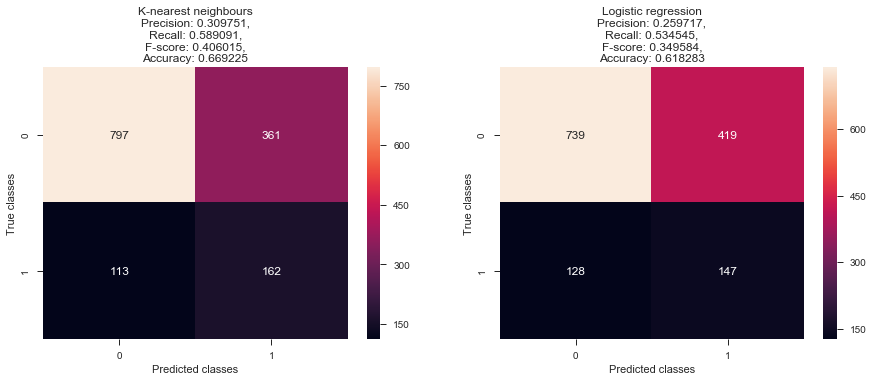

In [37]:
show_quality_results(y_test, k_n_y_pred, l_r_y_pred)

## Hyperparameters tunning

In [38]:
strategies = ['mean', 'median', 'most_frequent']
balancers = [RandomUnderSampler(random_state=42), RandomOverSampler(random_state=42), ClusterCentroids(random_state=42), ADASYN(random_state=42)]

In [39]:
n_neighbors = [3, 4, 5, 6, 7, 8]
leaf_size = [5, 10, 15, 20, 25, 30, 35]
p = [1, 2]
algorithm = ['ball_tree', 'kd_tree']

In [40]:
C = np.arange(0.1, 10.0, 0.5)
class_weight = [{False: 1.0, True: w} for w in np.arange(1, 10.0, 1.0)]
penalty = ['l1', 'l2']
fit_intercept = [True, False]

In [41]:
k_n_grid_search_params = [
    {
        'impute__strategy': strategies,
        'balancer': balancers,
        'fit': [KNeighborsClassifier()],
        'fit__n_neighbors': n_neighbors,
        'fit__leaf_size': leaf_size,
        'fit__p': p,
        'fit__algorithm': algorithm
    }
]
l_r_grid_search_params = [
    {
        'impute__strategy': strategies,
        'balancer': balancers,
        'fit': [LogisticRegression(random_state=42)],
        'fit__C': C,
        'fit__class_weight': class_weight,
        'fit__penalty': penalty,
        'fit__fit_intercept': fit_intercept
    }
]

In [42]:
nearest_neighbors_pipeline = Pipeline([
    ('impute', MyImputer(strategy='median')),
    ('union', FeatureUnion([
        ('binary', Pipeline([
            ('select', ItemSelector(binary_features))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features)),
            ('scale', StandardScaler()),
            ('transform', QuantileTransformer(random_state=42))
        ]))
    ])),
    ('balancer', RandomUnderSampler(random_state=42)),
    ('fit', KNeighborsClassifier())
])
k_n_grid_search = find_the_best_classifier(X_train, y_train, nearest_neighbors_pipeline, k_n_grid_search_params, 'f1')

In [ ]:
logistic_regression_pipeline = Pipeline([
    ('impute', MyImputer(strategy='median')),
    ('union', FeatureUnion([
        ('binary', Pipeline([
            ('select', ItemSelector(binary_features))
        ])),
        ('continuous', Pipeline([
            ('select', ItemSelector(continuous_features)),
            ('scale', StandardScaler()),
            ('transform', QuantileTransformer(random_state=42))
        ]))
    ])),
    ('balancer', RandomUnderSampler(random_state=42)),
    ('fit', LogisticRegression(random_state=42))
])
l_r_grid_search = find_the_best_classifier(X_train, y_train, logistic_regression_pipeline, l_r_grid_search_params, 'f1')

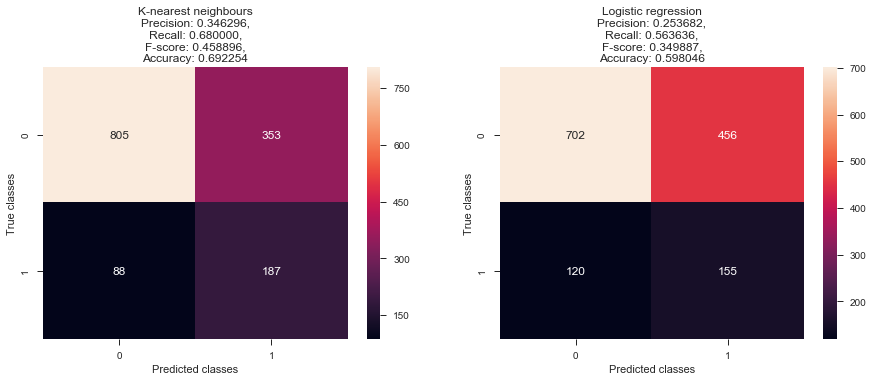

In [44]:
k_n_y_pred = k_n_grid_search.best_estimator_.predict(X_test)
l_r_y_pred = l_r_grid_search.best_estimator_.predict(X_test)
show_quality_results(y_test, k_n_y_pred, l_r_y_pred)

In [225]:
def reorganize_results(cv_results, grid_search_params):
    table_columns = list(grid_search_params[0].keys())

    data = {table_columns[i]: [cv_results['params'][j][table_columns[i]] for j in range(len(cv_results['params']))] for i in range(len(table_columns))}

    data['balancer'] = list(map(lambda x: x.__class__.__name__, data['balancer']))
    data['fit'] = list(map(lambda x: x.__class__.__name__, data['fit']))

    data['accuracy'] = cv_results['mean_test_accuracy']
    data['precision'] = cv_results['mean_test_precision']
    data['recall'] = cv_results['mean_test_recall']
    data['F_score'] = cv_results['mean_test_f1']

    table_columns.append('accuracy')
    table_columns.append('precision')
    table_columns.append('recall')
    table_columns.append('F_score')

    return pd.DataFrame(data=data, columns=table_columns)

In [226]:
k_n_results = reorganize_results(k_n_grid_search.cv_results_, k_n_grid_search_params)

In [227]:
k_n_results.sort_values('F_score', ascending=False).head()

impute__strategy            balancer                   fit  \
204             mean  RandomUnderSampler  KNeighborsClassifier   
205           median  RandomUnderSampler  KNeighborsClassifier   
133           median  RandomUnderSampler  KNeighborsClassifier   
169           median  RandomUnderSampler  KNeighborsClassifier   
168             mean  RandomUnderSampler  KNeighborsClassifier   

     fit__n_neighbors  fit__leaf_size  fit__p fit__algorithm  accuracy  \
204                 7              30       1      ball_tree  0.688338   
205                 7              30       1      ball_tree  0.688338   
133                 7              20       1      ball_tree  0.688338   
169                 7              25       1      ball_tree  0.688338   
168                 7              25       1      ball_tree  0.688338   

     precision    recall   F_score  
204   0.358837  0.724875  0.479666  
205   0.358837  0.724875  0.479666  
133   0.358837  0.724875  0.479666  
169   0.358837  0.724875  0.479666  
168   0.358837  0.724875  0.479666

In [257]:
l_r_results = reorganize_results(l_r_grid_search.cv_results_, l_r_grid_search_params)
fit__class_weight = l_r_results.fit__class_weight
l_r_results.drop(['fit__class_weight'], axis='columns', inplace=True)
l_r_results['fit__class_weight'] = fit__class_weight.apply(lambda x: x[True])

In [258]:
l_r_results.sort_values('F_score', ascending=False).head()

impute__strategy balancer                 fit  fit__C fit__penalty  \
6485    most_frequent   ADASYN  LogisticRegression     0.1           l2   
6484           median   ADASYN  LogisticRegression     0.1           l2   
6483             mean   ADASYN  LogisticRegression     0.1           l2   
6588             mean   ADASYN  LogisticRegression     0.6           l1   
6589           median   ADASYN  LogisticRegression     0.6           l1   

      fit__fit_intercept  accuracy  precision    recall   F_score  \
6485                True  0.592019   0.278266  0.652259  0.389651   
6484                True  0.592019   0.278266  0.652259  0.389651   
6483                True  0.592019   0.278266  0.652259  0.389651   
6588                True  0.596147   0.279094  0.643584  0.388972   
6589                True  0.596147   0.279094  0.643584  0.388972   

      fit__class_weight  
6485                1.0  
6484                1.0  
6483                1.0  
6588                1.0  
6589                1.0

Посмотрим на зависимость качества классификации при разных стратегиях балансировки классов:

In [261]:
def plot_results(results, metric, impute_strategy, algorithm):
    balancers = ['RandomUnderSampler', 'ClusterCentroids', 'RandomOverSampler', 'ADASYN']
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    f, axes = plt.subplots(1, len(balancers), figsize=(35, 10), sharey=True)
    f.suptitle('{} by leaf size for different balancers and different neighbors count'.format(metric), fontsize=22)
    for balancer, ax in zip(balancers, axes):
        for i in range(len(n_neighbors)):
            mask = (results.balancer == balancer) & (results.fit__n_neighbors == n_neighbors[i]) & (k_n_results.impute__strategy == impute_strategy) & (results.fit__p == 1) & (results.fit__algorithm == algorithm)
            ax.plot(leaf_size, results[mask][[metric]], colors[i])
        ax.set_title('Balancer: {},\nImpute strategy: {}, Algorithm: {}'.format(balancer, impute_strategy, algorithm), fontsize=18)
        ax.set_xticks(leaf_size)
        ax.set_xlabel('leaf size')
        ax.legend(list(map(lambda x: 'neighbors count: {}'.format(x), n_neighbors)), loc=0, fontsize=18)
    plt.show()

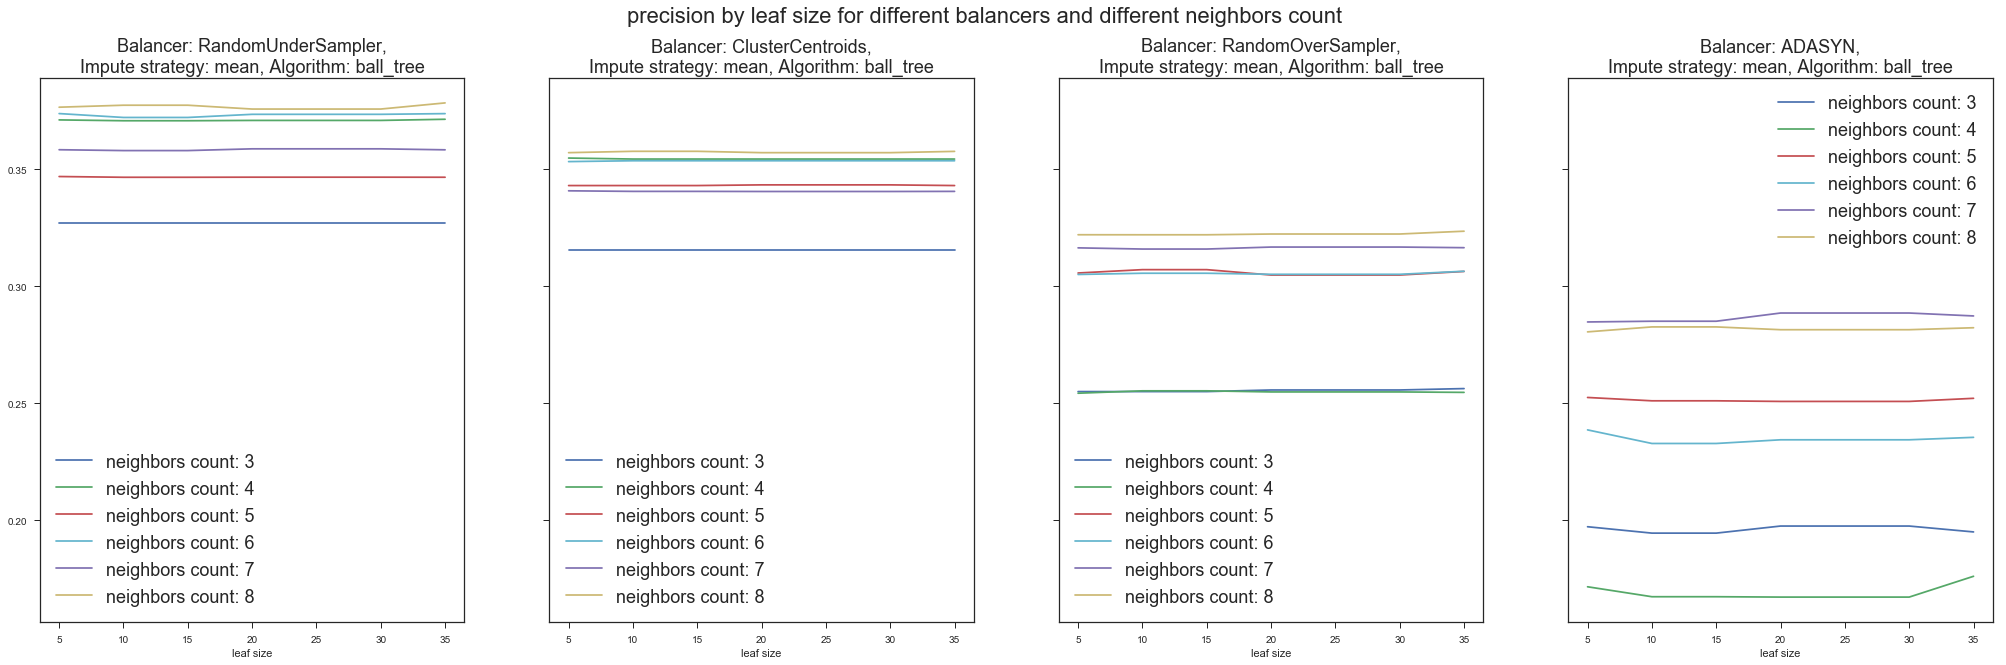

In [262]:
plot_results(k_n_results, 'precision', 'mean', 'ball_tree')

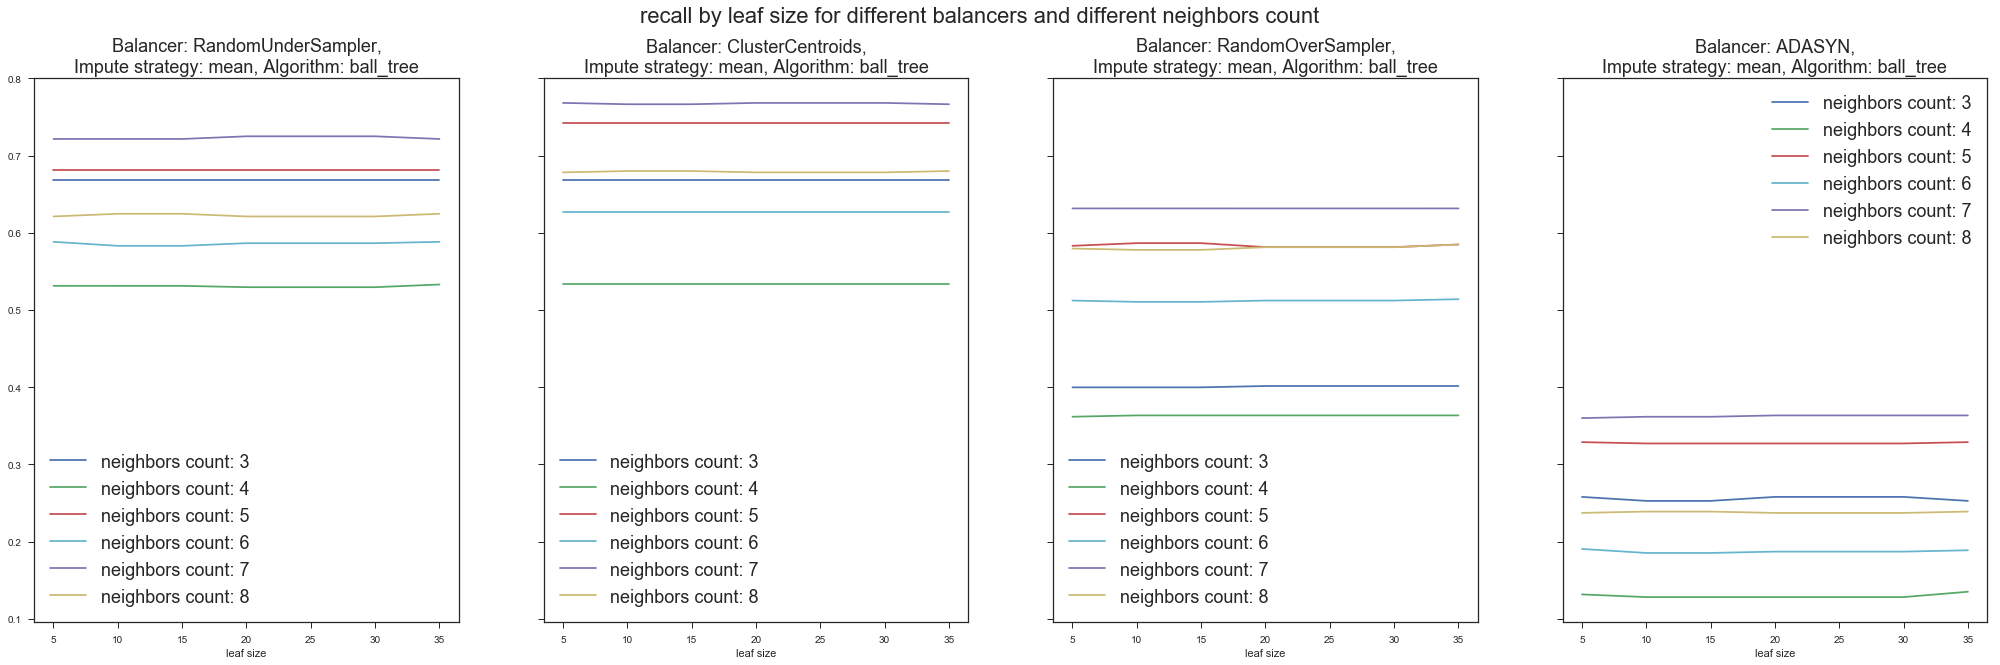

In [263]:
plot_results(k_n_results, 'recall', 'mean', 'ball_tree')

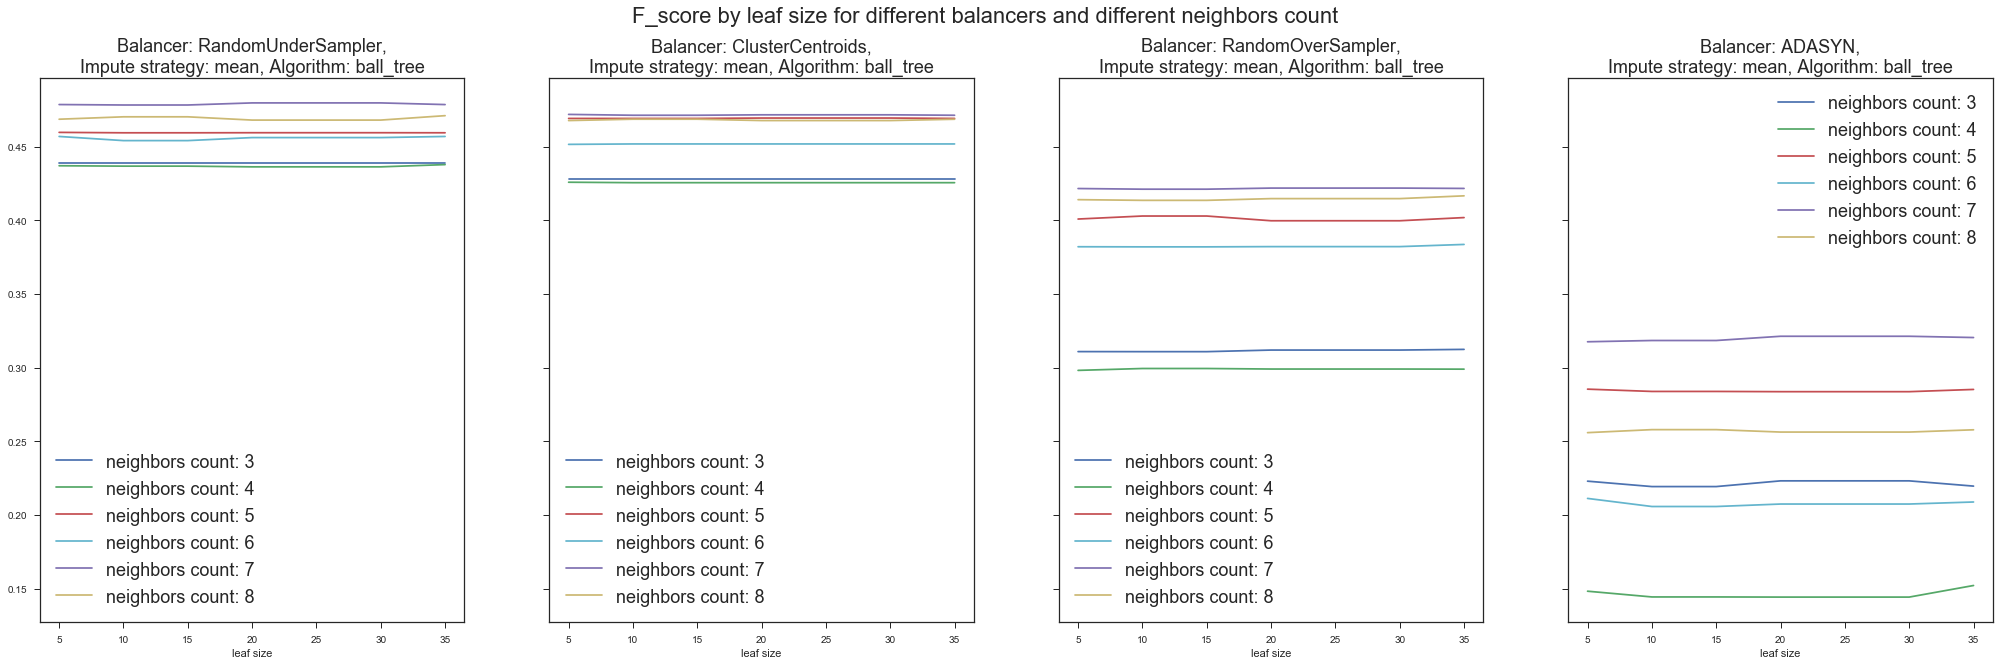

In [264]:
plot_results(k_n_results, 'F_score', 'mean', 'ball_tree')

Как видно из данных графиков, максимальных значений полноты удается достигать с помощью RandomUnderSampler-а, задав количество соседей, равное 7.

Впрочем, для достижения максимальной полноты лучше сработал ClusterCentroids.

Максимальной точности удается достичь при количестве соседей, равном 8 (при всех способах балансировки, кроме ADASYN, там лучше срабатывает количество, равное 7).

Попробуем теперь вывести те же графики для других способов заполнения пропусков:

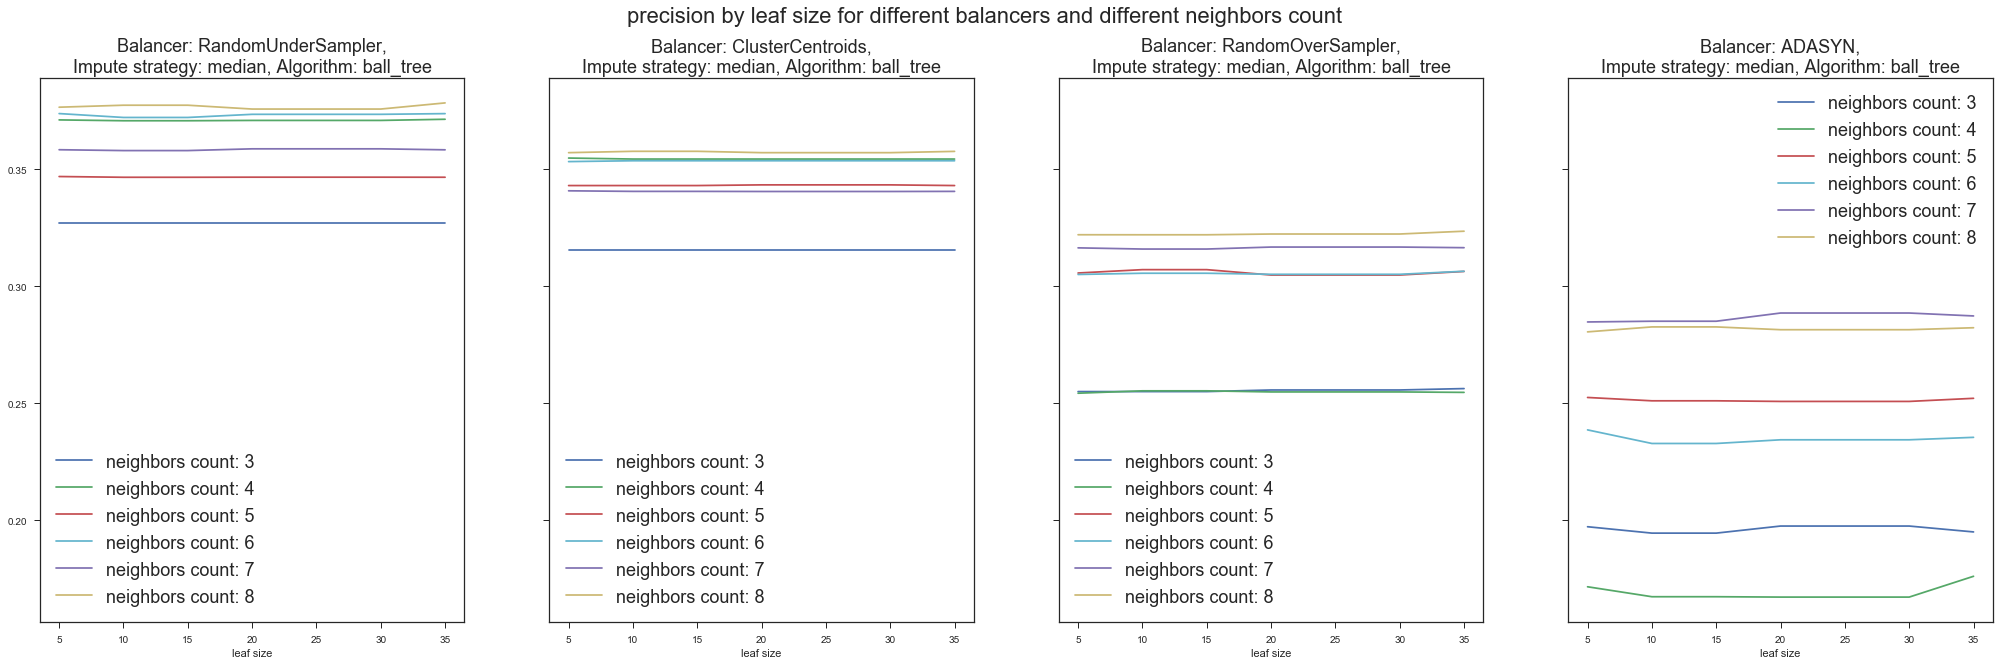

In [265]:
plot_results(k_n_results, 'precision', 'median', 'ball_tree')

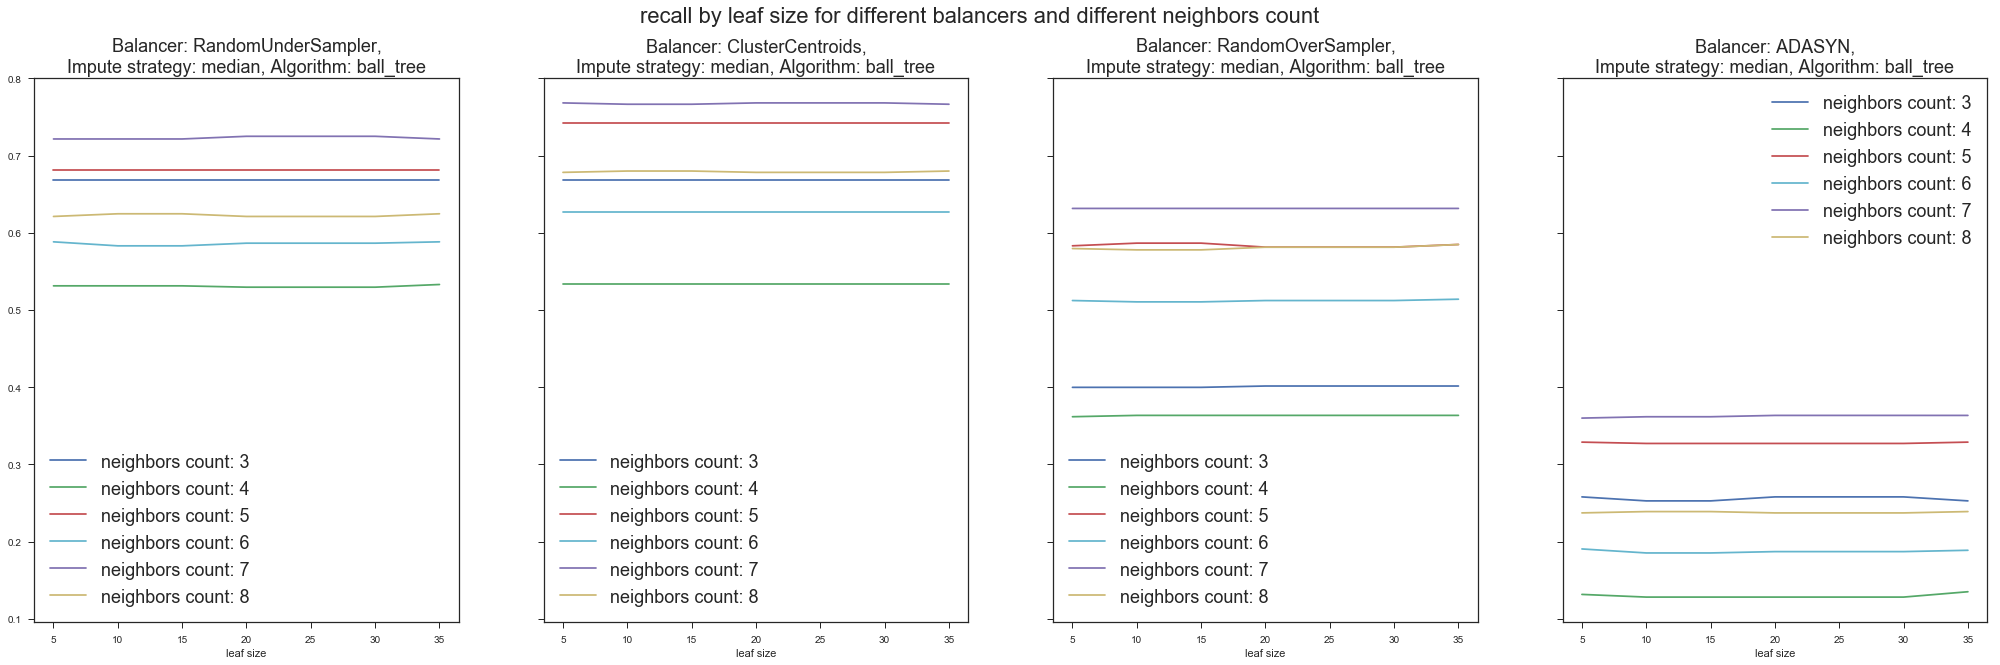

In [266]:
plot_results(k_n_results, 'recall', 'median', 'ball_tree')

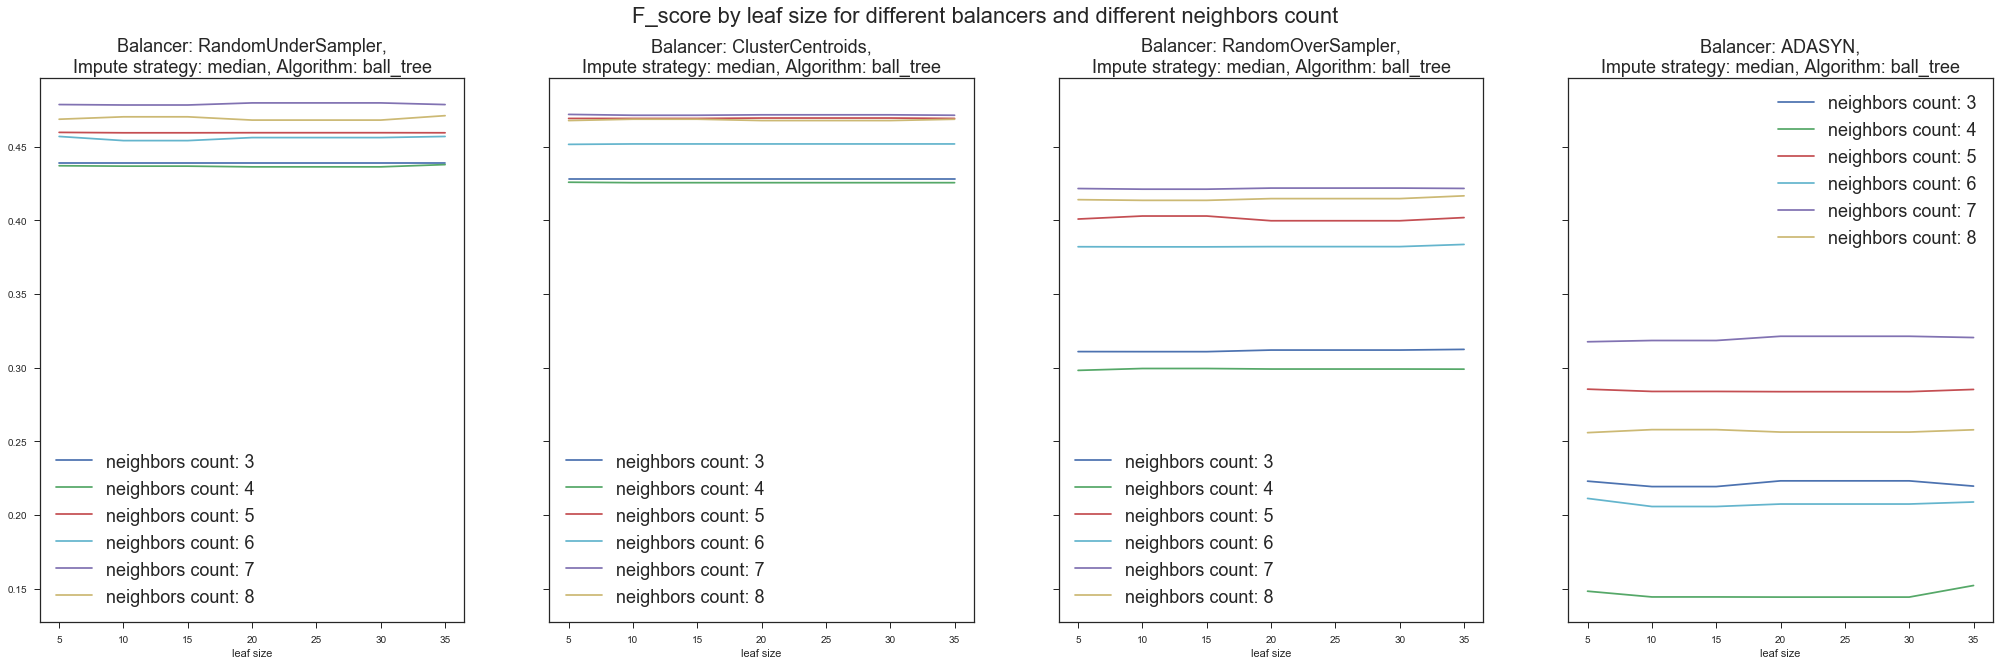

In [267]:
plot_results(k_n_results, 'F_score', 'median', 'ball_tree')

Для заполения медианами картина примерно такая же, что и для заполнения средними.

Взглянем теперь на то, как при разных гиперпараметрах меняется качество у логистической регрессии:

In [337]:
def plot_results(results, metric, impute_strategy, penalty, fit_intercept):
    balancers = [['RandomUnderSampler', 'ClusterCentroids'], ['RandomOverSampler', 'ADASYN']]
    
    f, axes = plt.subplots(2, 2, figsize=(75, 40))
    f.suptitle('{} by regularization coefficient  and positive class weight for different balancers'.format(metric), fontsize=42)
    sns.set(font_scale=3)
    for i in range(2):
        for j in range(2):
            mask = (results.impute__strategy == impute_strategy) & (results.balancer == balancers[i][j]) & (results.fit__penalty == penalty) & (results.fit__fit_intercept == fit_intercept)
            sns.heatmap(results[mask].pivot(index='fit__C', columns='fit__class_weight', values=metric), annot=True, fmt='.4f', ax=axes[i, j])
            axes[i, j].set_title('Balancer: {}, Impute strategy: {},\nPenalty: {}, Fit intersept: {}'.format(balancers[i][j], impute_strategy, penalty, fit_intercept), fontsize=38)
    plt.show()

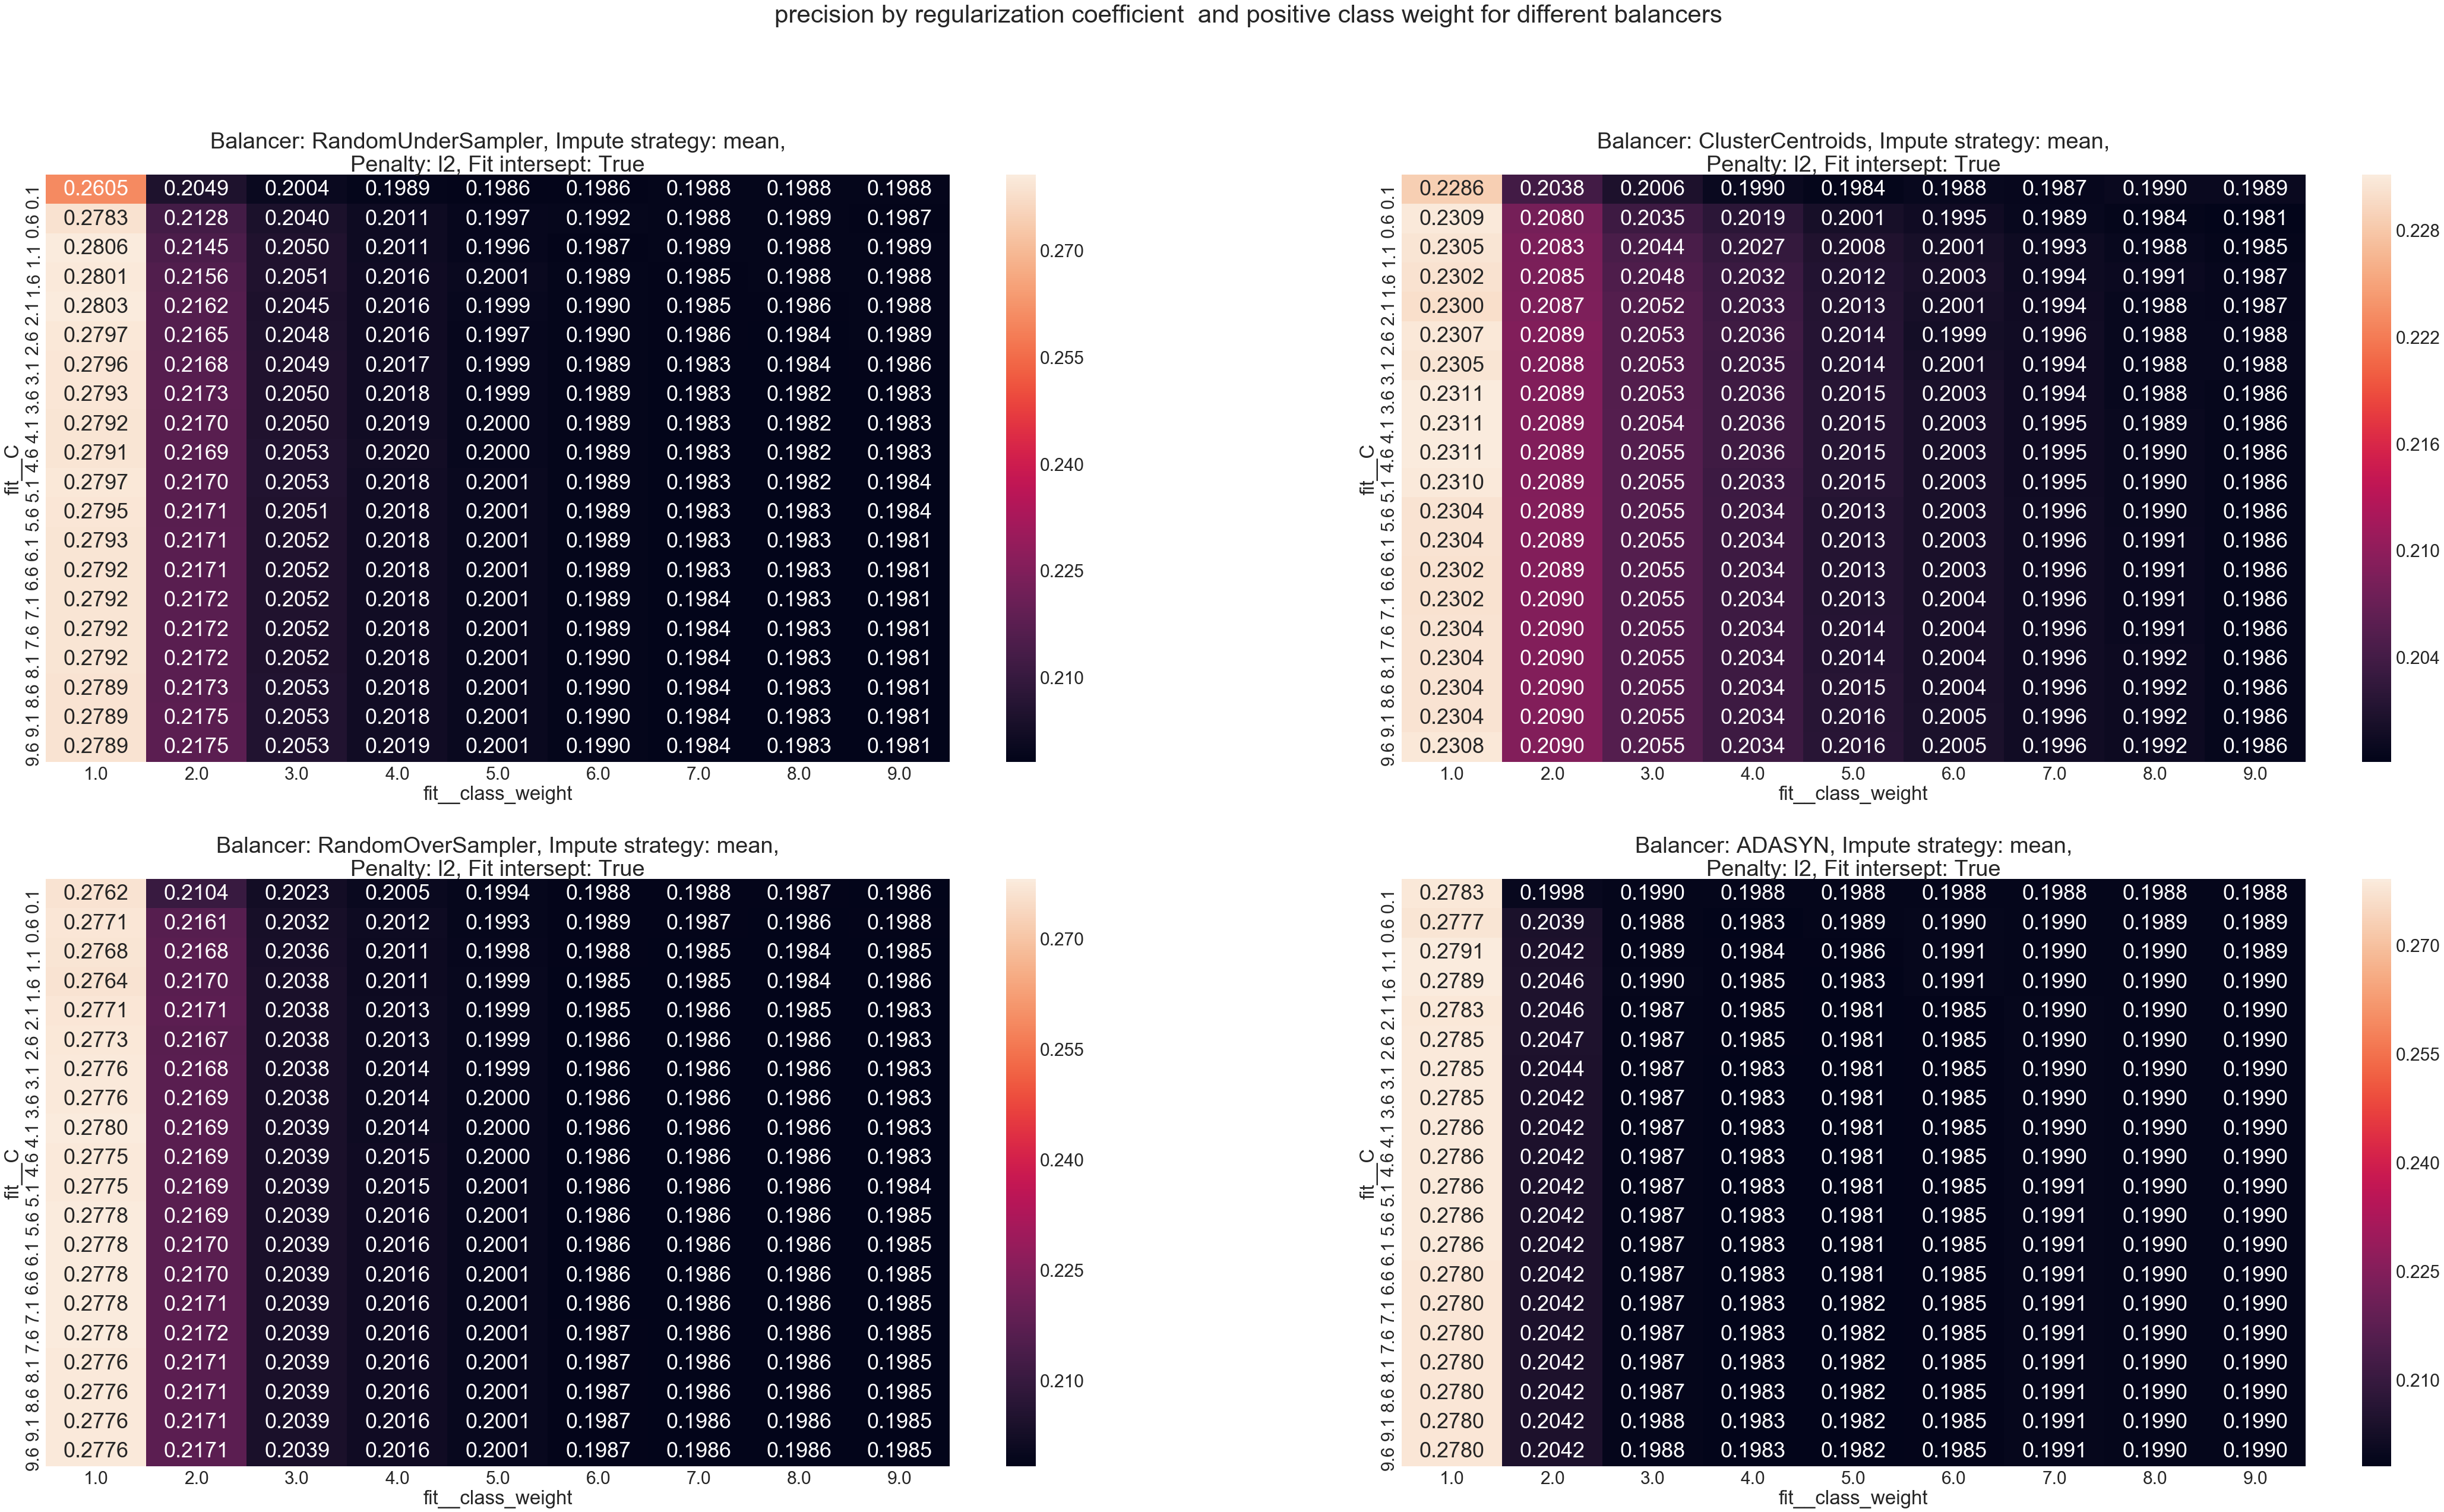

In [343]:
plot_results(l_r_results, 'precision', 'mean', 'l2', True)

Максимальной (вреди прочего) точности удается достигать при ADASYN балансировке.

Взглянем на полноту:

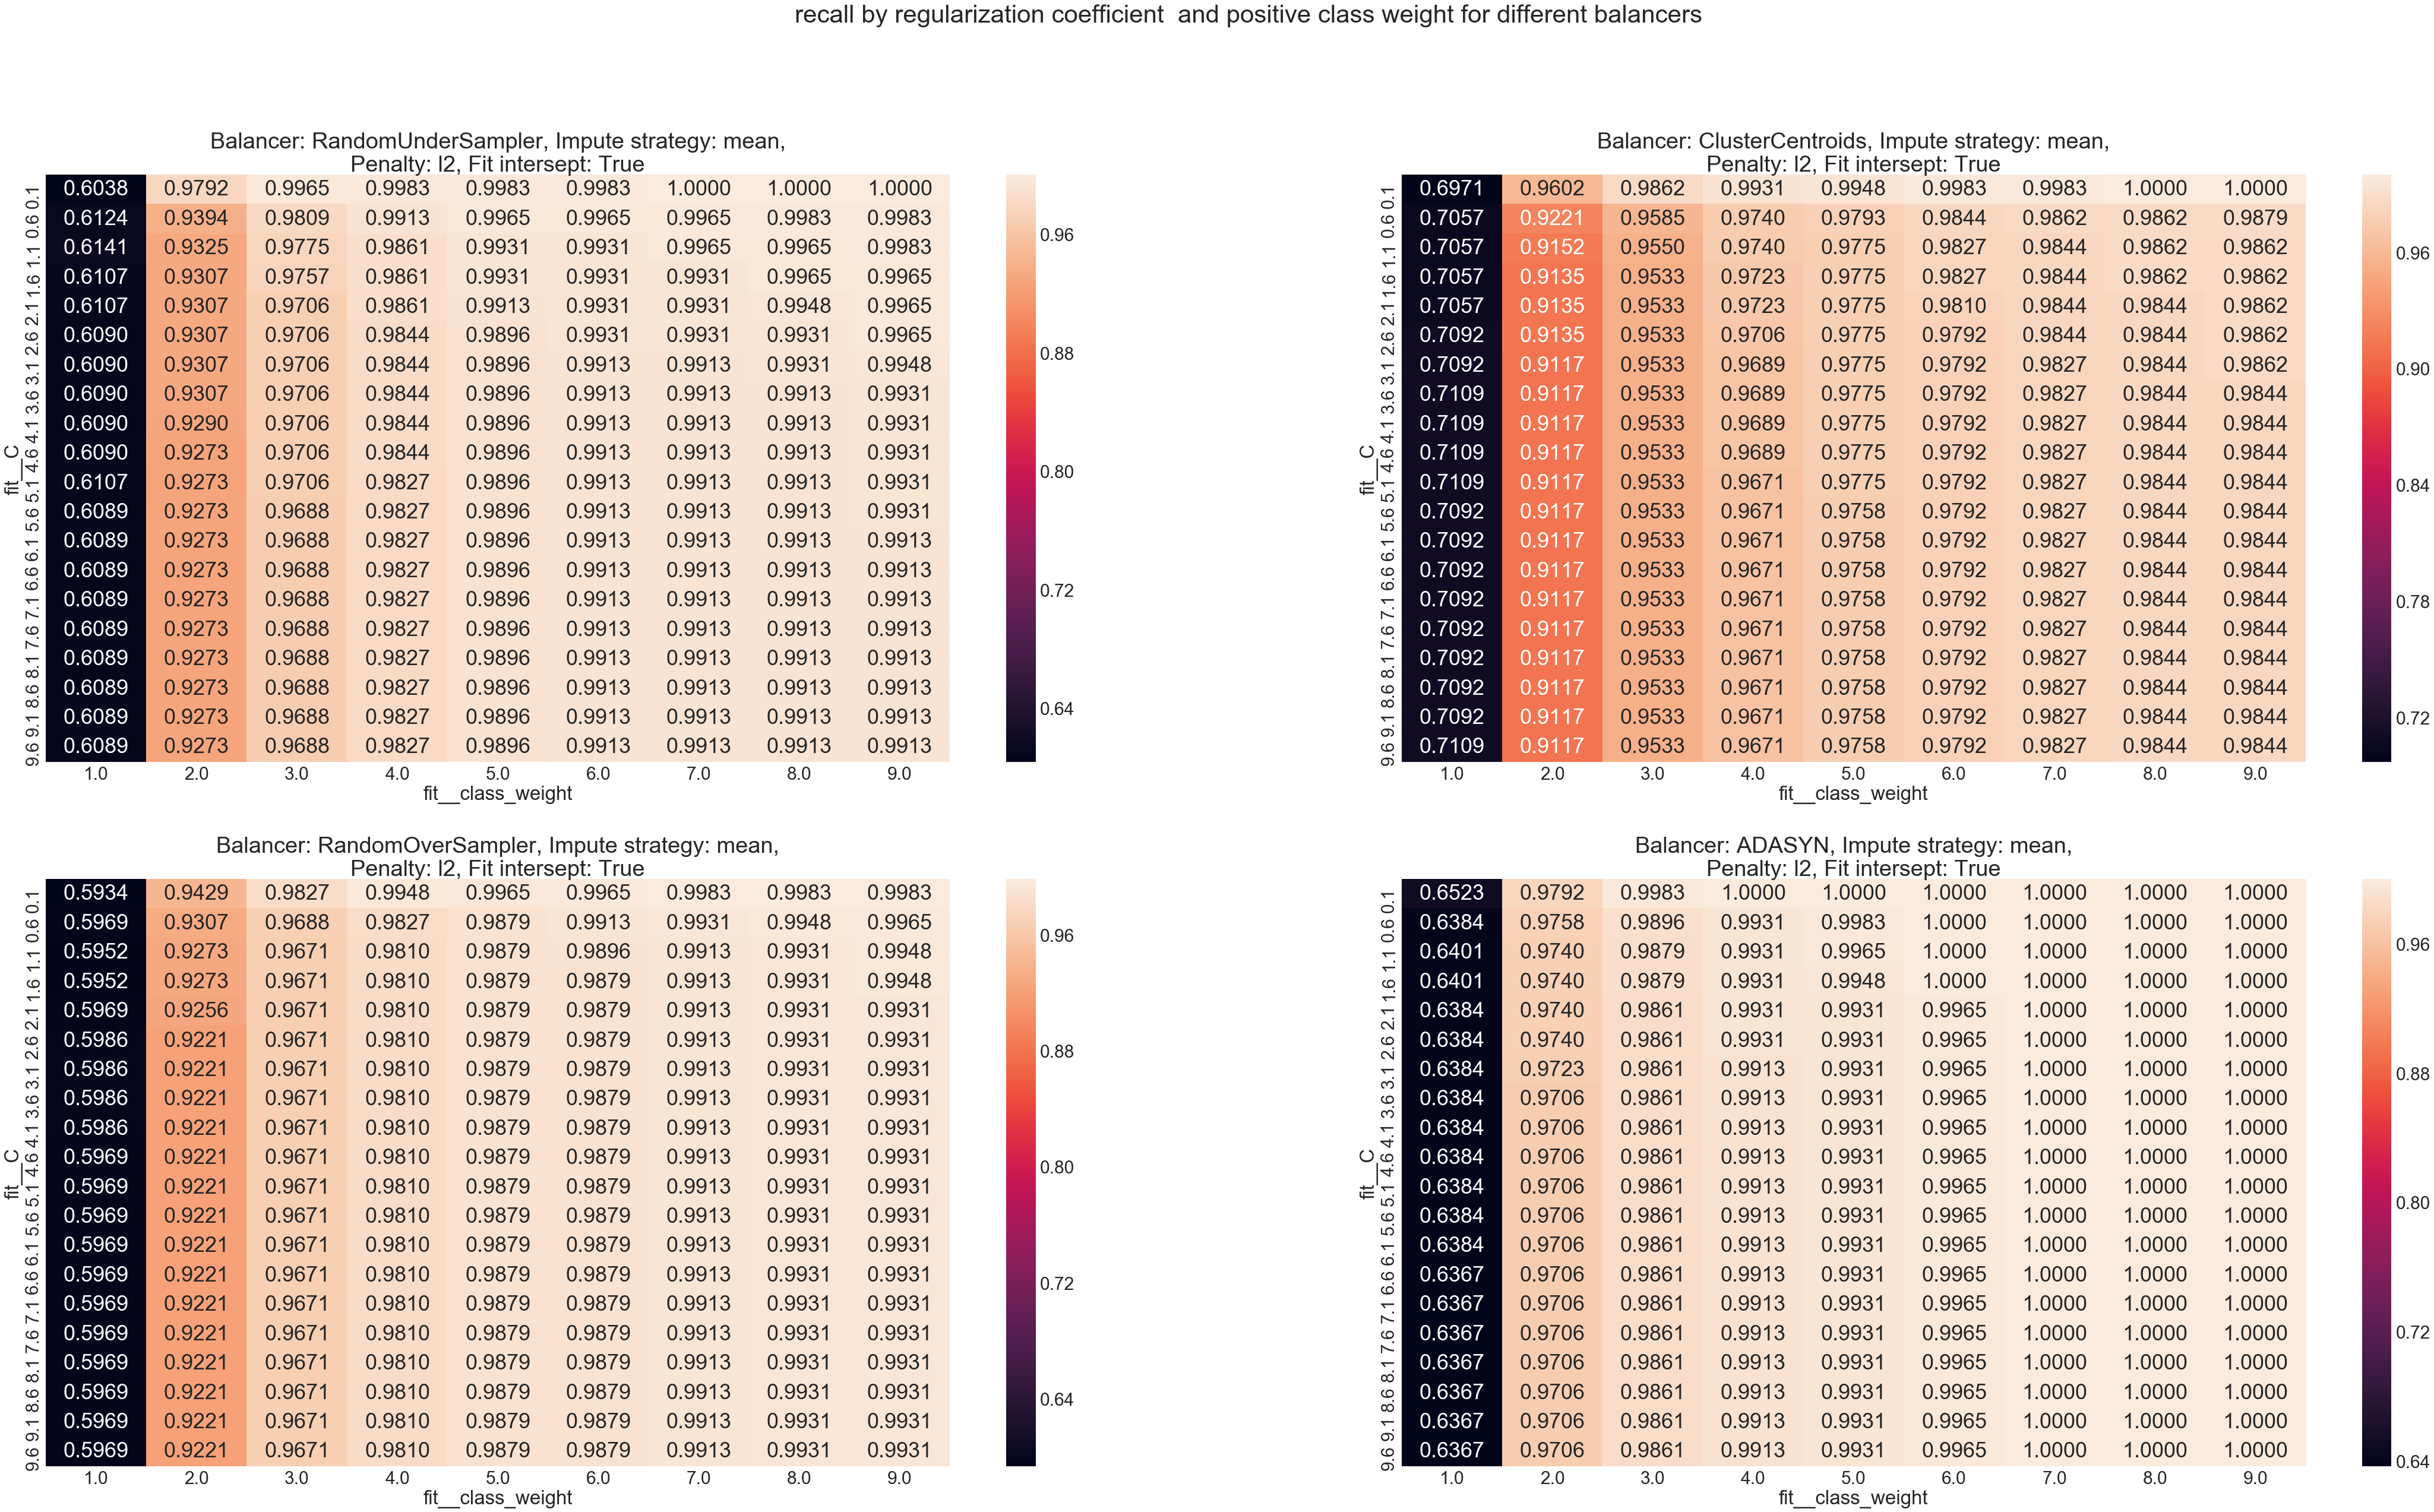

In [346]:
plot_results(l_r_results, 'recall', 'mean', 'l2', True)

Правые части графиков показывают очень высокое значение полноты, однако если обратить внимание на аналогичные ячейки в графиках точности, то становится понятно, что такая полнота достигается с сильным ущербом для точности, поэтому нельзя говорить об этом, как о хорошем результате.

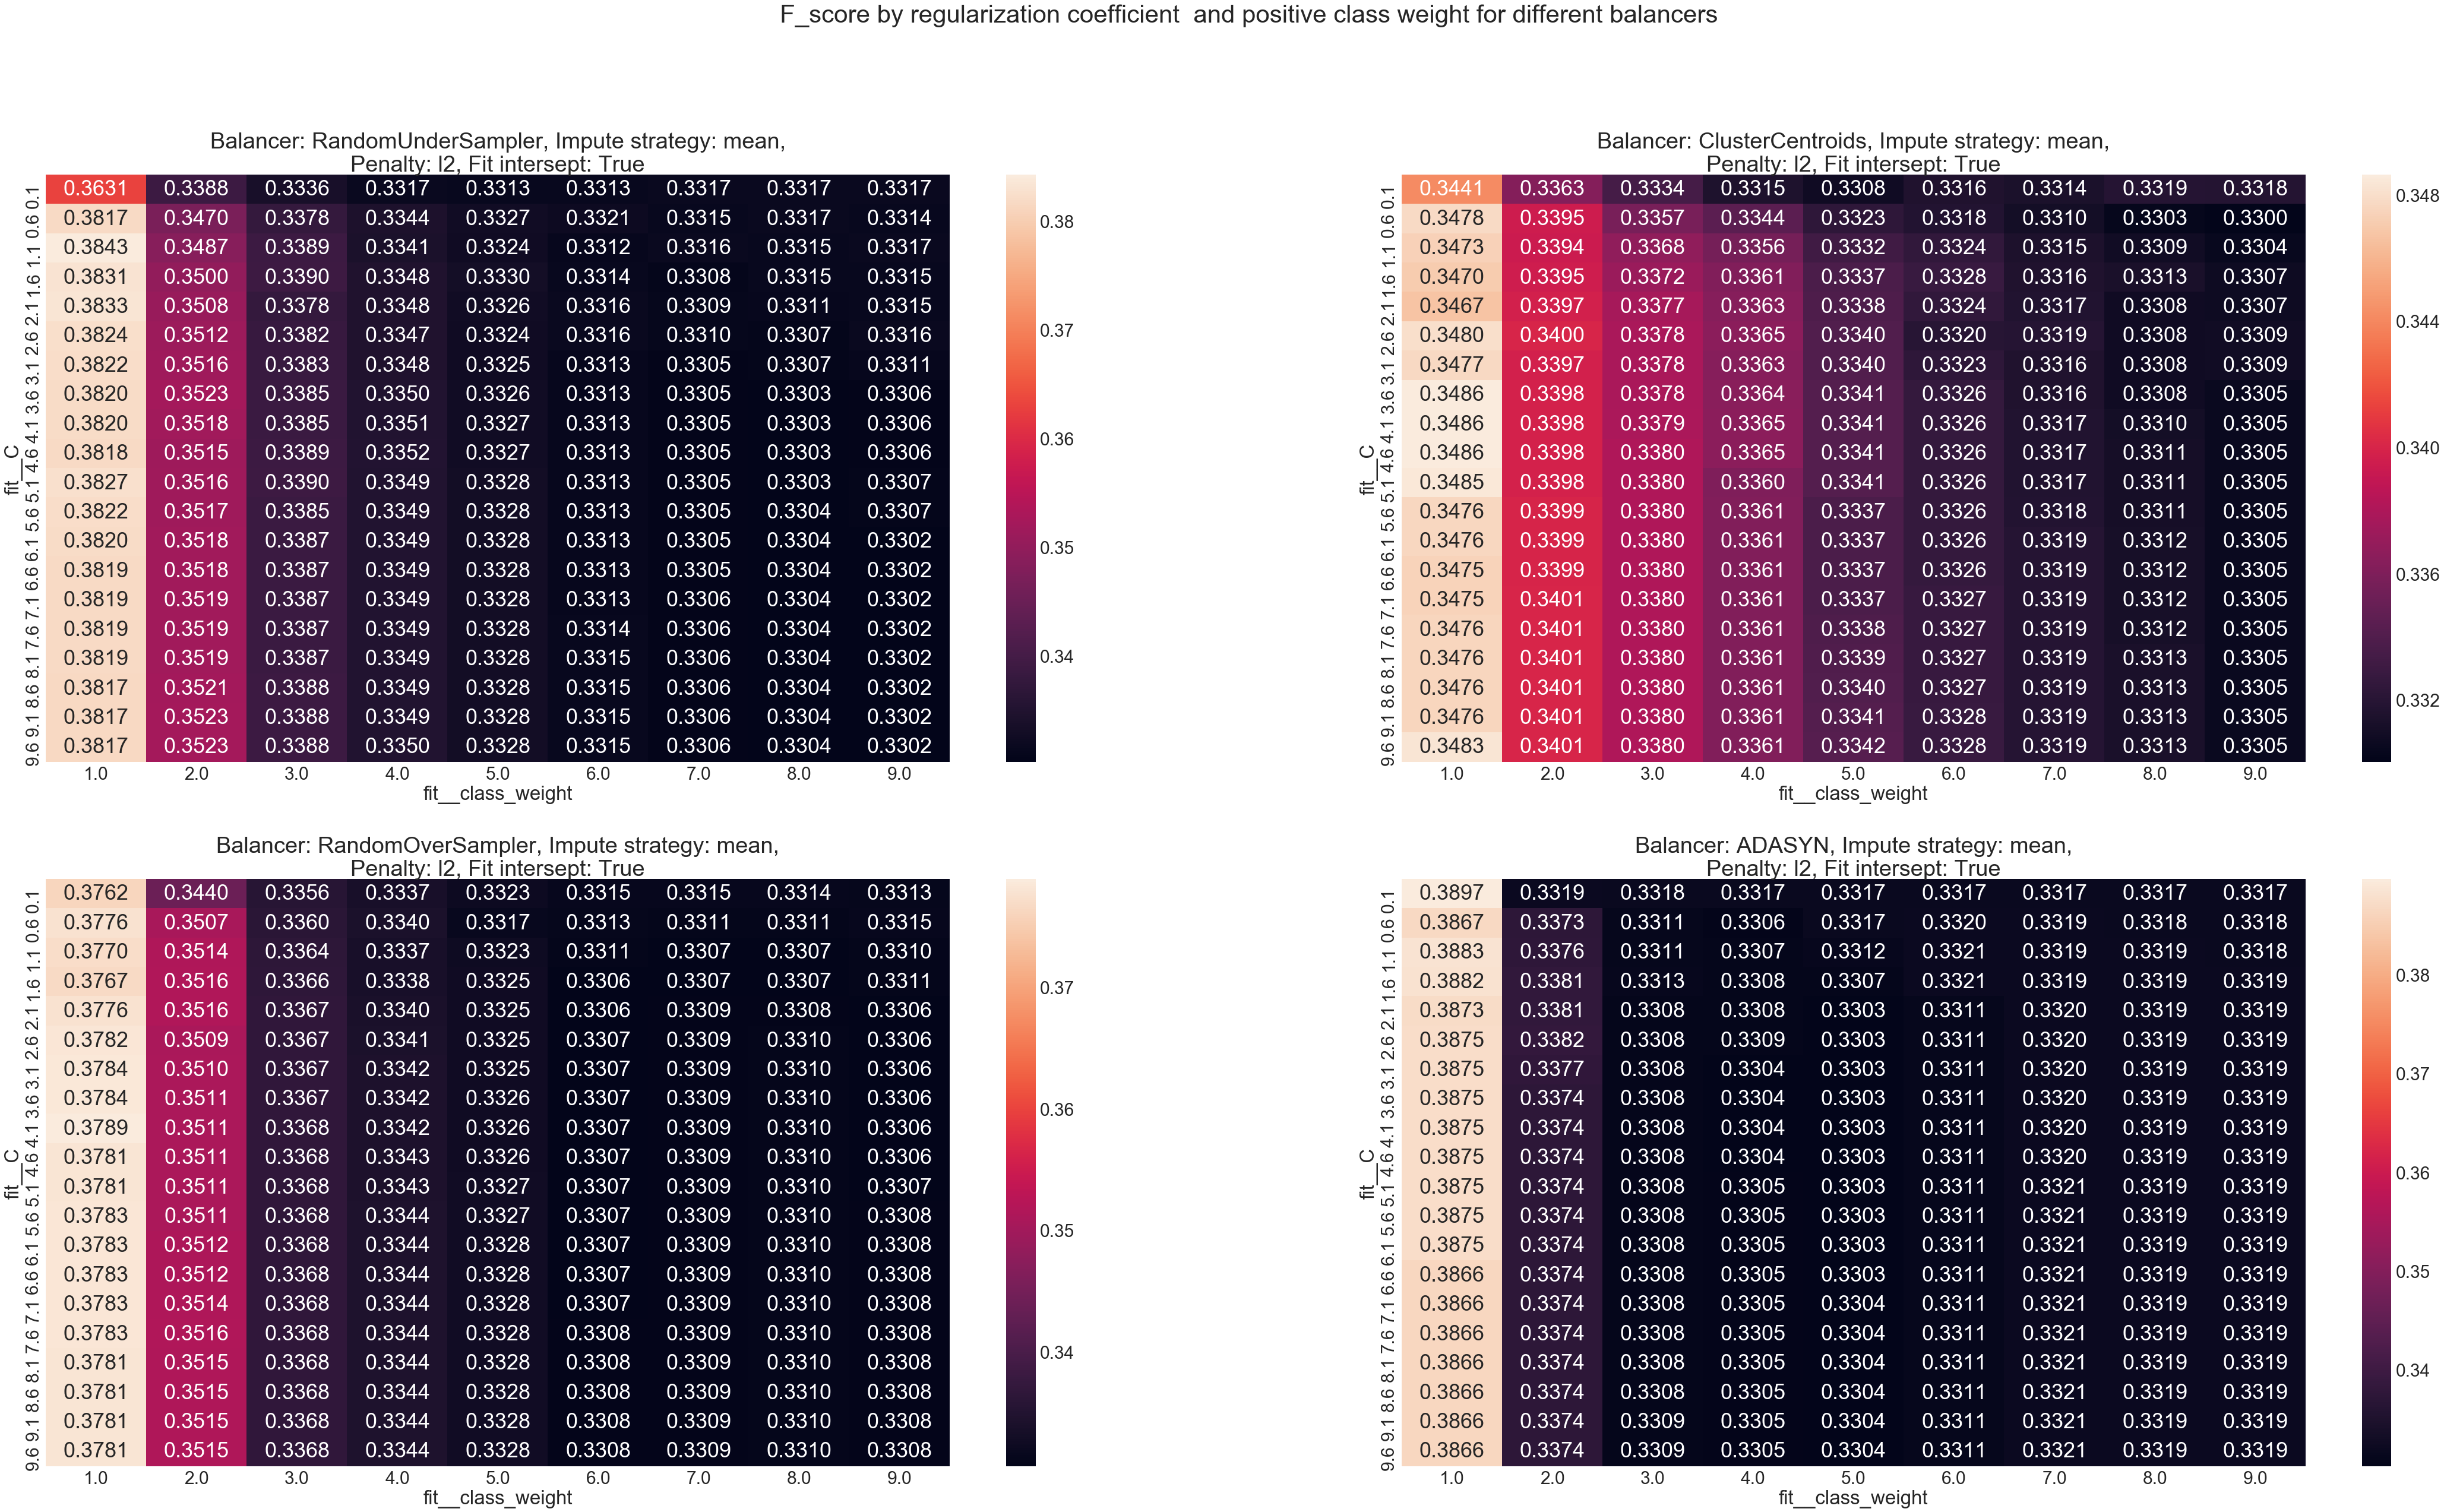

In [347]:
plot_results(l_r_results, 'F_score', 'mean', 'l2', True)

Здесь лучшее значение F-score достигается за счет ADASYN балансировки, коэффициенте L2-регуляризации 0.1, равном весе классов.

## Conclusion

Итак, в данной работе была:
    - проведена предварительная обработка данных посредством заполнения пропусков, нормализации признаков, исключения неинформативных признаков и т.д.;
    - построена базовая модель для логистической регрессии и медота К-ближайших соседей;
    - проверено два способа undersampling-а и oversampling-а с использованием поиска оптимальных гиперпараметров по сетке и стратифицированного перекрестного контроля;
    - графически отображена зависимость метрик от различных значений гиперпараметров.

То, что не вошло в данную работу, но, возможно, улучшило бы качество классификации:
    - включение referal source в выборку с последующей его бинаризацией;
    - использование других способов заполнения пропусков;
    - использование других стратегий undersampling-а;
    - использование данных о больных, у которых не был указан пол.

Стоит отметить, что:
    - использование undersampling-a существенно повысило качество классификации;
    - дальнейший поиск оптимальной комбинации гиперпараметров также помог, но в меньшей степени;
    - для оптимизации полноты по методу К-ближайших соседей оптимальной метрикой (при разных значениях прочих гиперпараметров) оказывается метрика Манхэттена;
    - для логистической регрессии оптимизация полноты дала лучшие результаты при L2-регуляризации;
    - использование разных весов классов в логистической регрессии не дало существенного улучшения результатов.

В целом, по имеющимся оценкам можно прийти к выводу, что метод К-ближайших соседей работает лучше, поскольку превосходит логистическую регрессию как в точности, так и в полноте.